In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from skorch import NeuralNetRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib

sns.set(style='whitegrid')

# Prediction of Breakthrough Pressure with 2 Variables: Direct Tests

## Exploratory Data Analysis

In [3]:
# Load the dataset
df = pd.read_csv('2.csv')
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Number of data points,Reference,Rock,P’[MPa],Permeability [nD],Permeability25 [nD],Porosity [%],Porosity25 [%],Breakthrough pressure [MPa],Breakthrough pressure25 [MPa]
0,1,Amann-Hildenbrand 2013,Opalinus Clay,25,6.87,6.87,11.6,11.60,4.10,4.10
1,2,Boulin et al. 2011,Claystone,5,16.50,3.80,15.0,13.60,1.74,3.60
2,3,Boulin et al. 2011,Claystone,7,31.80,9.95,15.0,13.88,10.40,7.25
3,4,Boulin et al. 2011,Claystone,25,15.60,15.60,15.0,15.00,13.00,13.00
4,5,Boulin et al. 2011,Claystone,25,14.50,14.50,15.0,15.00,13.00,13.00


In [680]:
# Display the summary statistics
print("\nSummary statistics:")
df.describe()


Summary statistics:


,Number of data points,P’[MPa],Permeability [nD],Permeability25 [nD],Porosity [%],Porosity25 [%],Breakthrough pressure [MPa],Breakthrough pressure25 [MPa]
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,24.000000,15.978723,17646.705957,11035.022340,16.518085,15.639149,5.130000,5.425745
std,13.711309,10.111314,119680.126240,75099.761508,14.681785,13.404104,4.243829,4.038296
min,1.000000,1.000000,0.100000,0.060000,0.040000,0.040000,0.100000,0.340000
25%,12.500000,7.000000,5.190000,3.630000,2.200000,2.155000,1.535000,2.455000
50%,24.000000,15.000000,19.500000,14.050000,15.000000,14.190000,4.100000,4.100000
75%,35.500000,21.000000,52.920000,19.955000,24.000000,23.680000,8.600000,7.190000
max,47.000000,42.000000,820668.690000,514935.780000,54.550000,49.460000,13.800000,14.540000


In [681]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Number of data points            0
Reference                        0
Rock                             0
P’[MPa]                          0
Permeability [nD]                0
Permeability25 [nD]              0
Porosity [%]                     0
Porosity25 [%]                   0
Breakthrough pressure [MPa]      0
Breakthrough pressure25 [MPa]    0
dtype: int64


In [682]:
# Check the data types of each column
print("\nData types of each column:")
print(df.dtypes)


Data types of each column:
Number of data points              int64
Reference                         object
Rock                              object
P’[MPa]                            int64
Permeability [nD]                float64
Permeability25 [nD]              float64
Porosity [%]                     float64
Porosity25 [%]                   float64
Breakthrough pressure [MPa]      float64
Breakthrough pressure25 [MPa]    float64
dtype: object


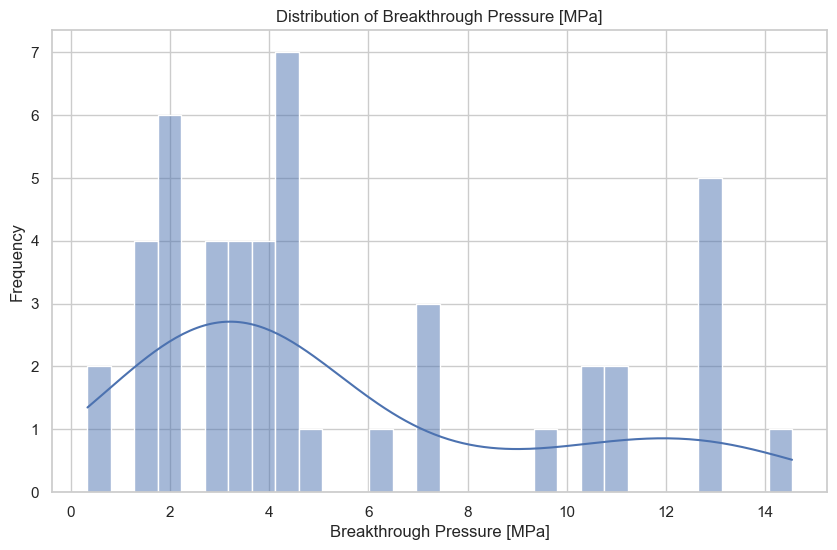

In [683]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Breakthrough pressure25 [MPa]'], bins=30, kde=True)
plt.title('Distribution of Breakthrough Pressure [MPa]')
plt.xlabel('Breakthrough Pressure [MPa]')
plt.ylabel('Frequency')
plt.show()

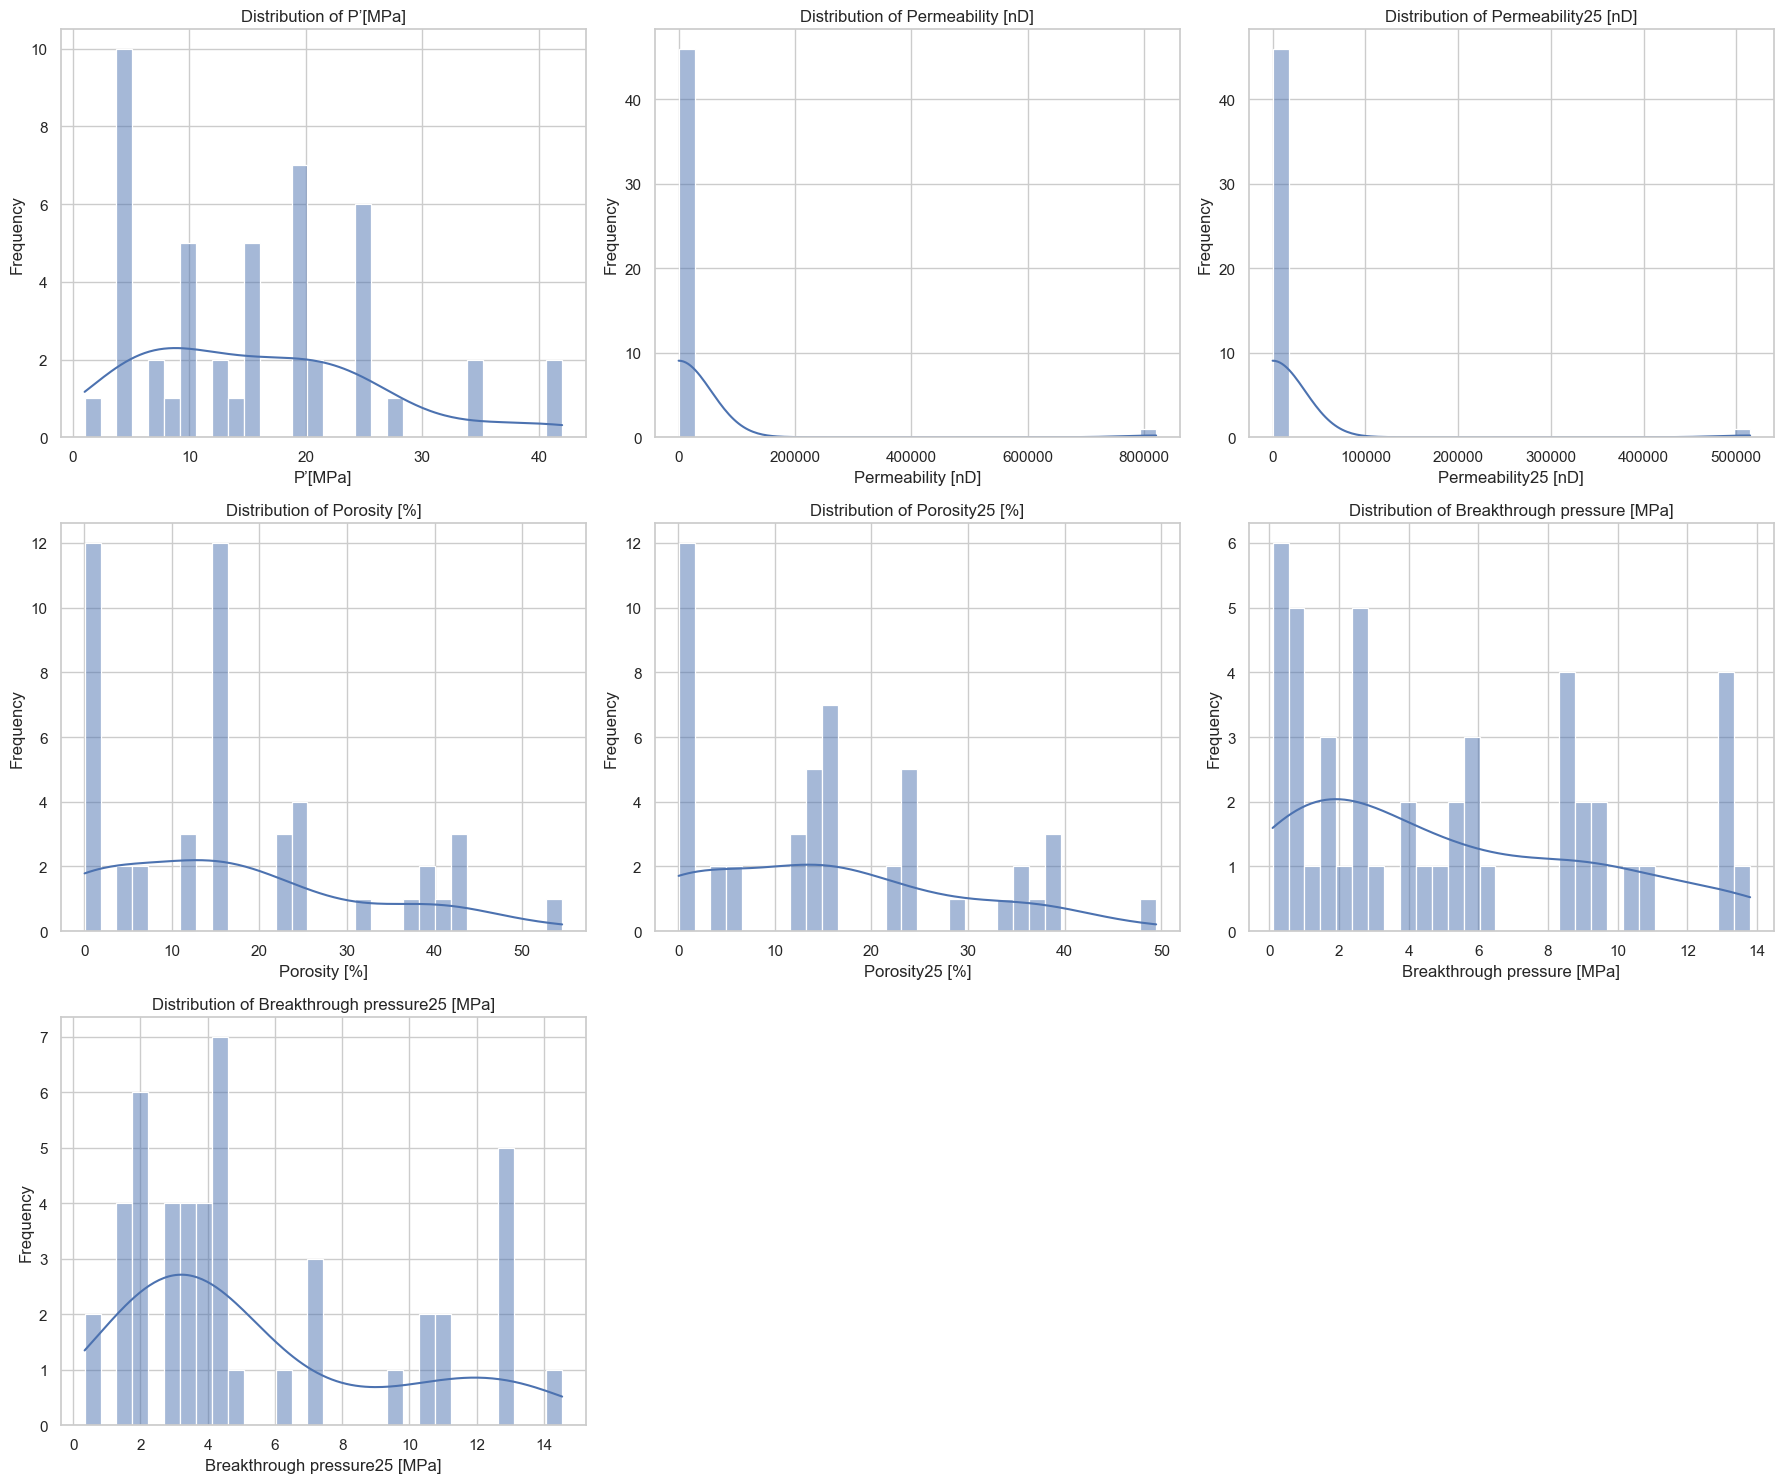

In [684]:
feature_columns = ['P’[MPa]', 'Permeability [nD]', 'Permeability25 [nD]', 
                   'Porosity [%]', 'Porosity25 [%]', 'Breakthrough pressure [MPa]', 
                   'Breakthrough pressure25 [MPa]']

num_features = len(feature_columns)
num_rows = (num_features + 2) // 3  
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(feature_columns):
    sns.histplot(df[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

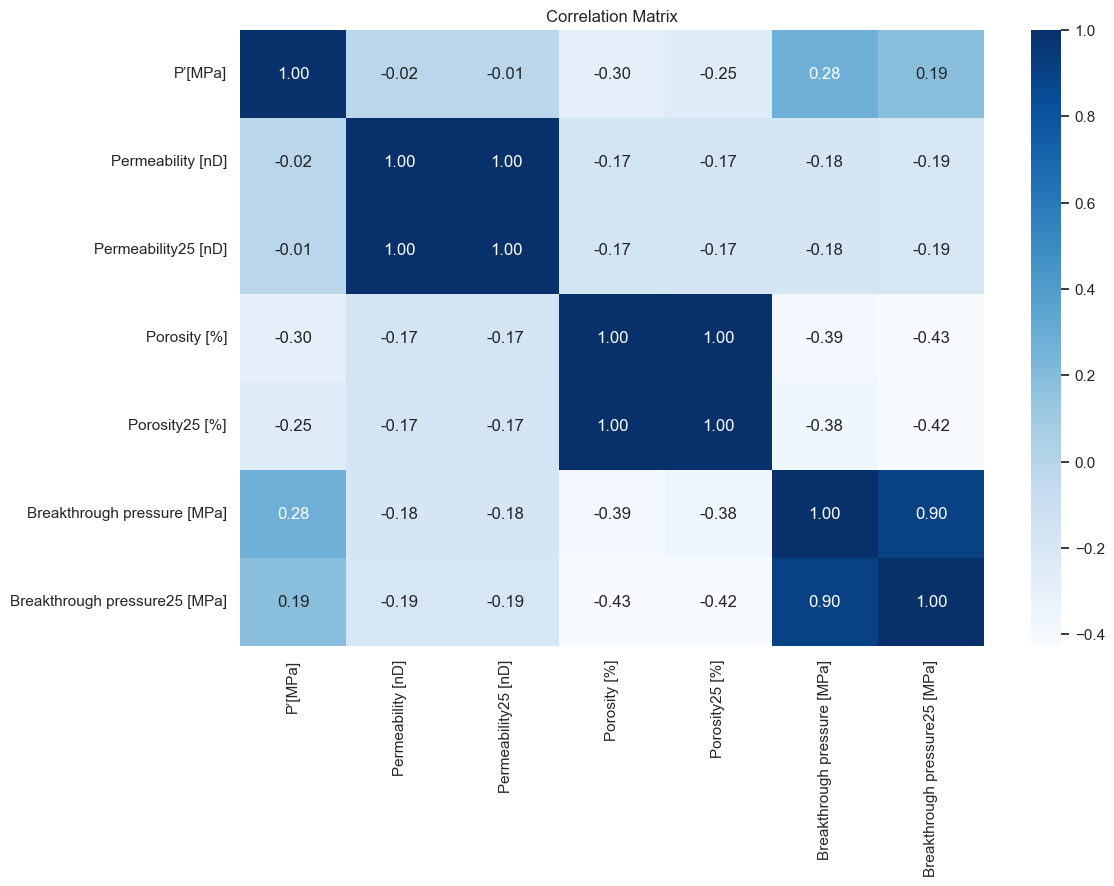

In [685]:
# Visualize correlations between features and the target variable
cols = ['P’[MPa]',
       'Permeability [nD]', 'Permeability25 [nD]', 'Porosity [%]',
       'Porosity25 [%]', 'Breakthrough pressure [MPa]',
       'Breakthrough pressure25 [MPa]']
correlation_matrix = df[cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

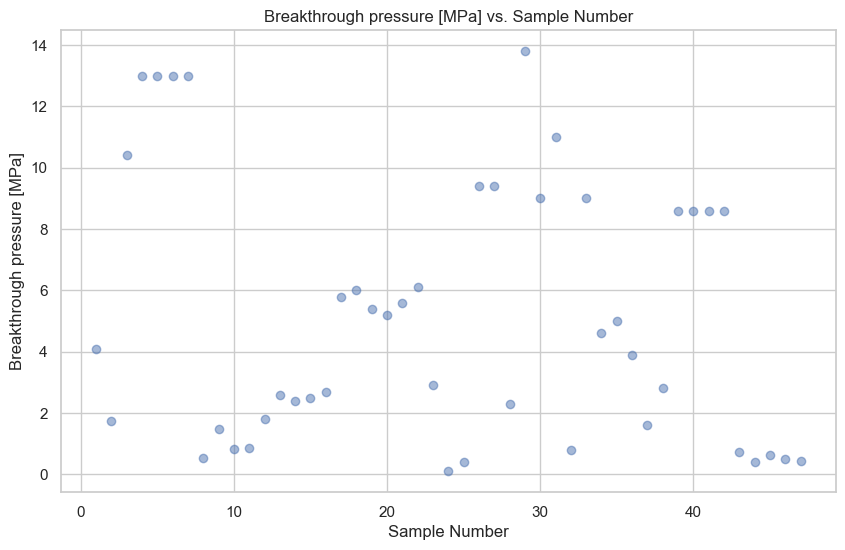

In [686]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Number of data points'], df['Breakthrough pressure [MPa]'], alpha=0.5)
plt.xlabel('Sample Number')
plt.ylabel('Breakthrough pressure [MPa]')
plt.title('Breakthrough pressure [MPa] vs. Sample Number')
plt.show()

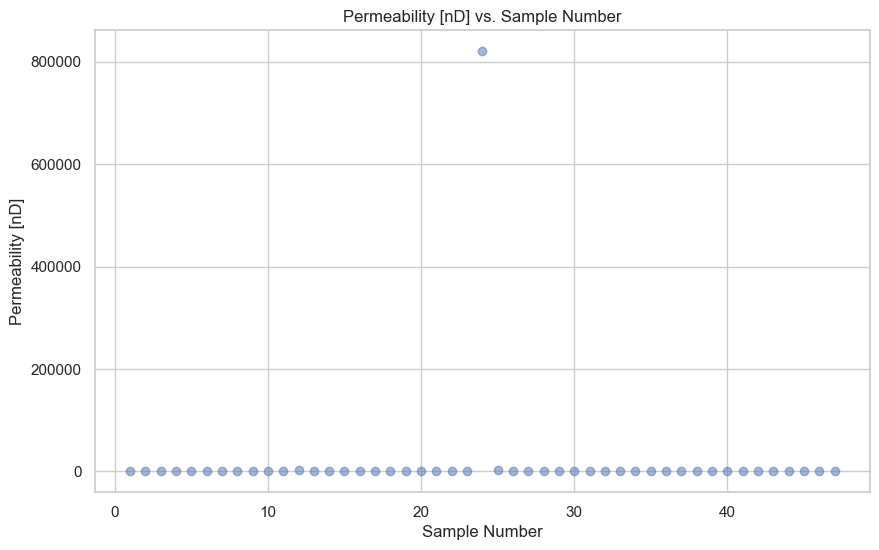

In [687]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Number of data points'], df['Permeability [nD]'], alpha=0.5)
plt.xlabel('Sample Number')
plt.ylabel('Permeability [nD]')
plt.title('Permeability [nD] vs. Sample Number')
plt.show()

## Data Preprocessing

In [23]:
feature_columns = ['P’[MPa]', 'Permeability [nD]', 'Permeability25 [nD]', 'Porosity [%]', 'Porosity25 [%]']
target_column= 'Breakthrough pressure [MPa]'

In [24]:
# Encoding
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [25]:
df.columns

Index(['Number of data points', 'Reference', 'Rock', 'P1', 'P2',
       'Permeability25 [nD]', 'P3', 'Porosity25 [%]', 'Target',
       'Breakthrough pressure25 [MPa]'],
      dtype='object')

In [26]:
# Feature Scaling
scaler_features = StandardScaler()
scaler_target = StandardScaler()

scaled_features = scaler_features.fit_transform(df[feature_columns])
scaled_target = scaler_target.fit_transform(df[[target_column]])

df[feature_columns] = scaled_features
df[target_column] = scaled_target

KeyError: "['P’[MPa]', 'Permeability [nD]', 'Porosity [%]'] not in index"

In [27]:
df.columns

Index(['Number of data points', 'Reference', 'Rock', 'P1', 'P2',
       'Permeability25 [nD]', 'P3', 'Porosity25 [%]', 'Target',
       'Breakthrough pressure25 [MPa]'],
      dtype='object')

In [9]:
# Replace special symbols in column names
df = df.rename(columns={"P’[MPa]": "P1", "Permeability [nD]": "P2", 
                        'Porosity [%]': 'P3', 'Breakthrough pressure [MPa]':'Target'})
df.columns = df.columns.str.replace('[^A-Za-z0-9]+', '_')
print(df.columns)

Index(['Number of data points', 'Reference', 'Rock', 'P1', 'P2',
       'Permeability25 [nD]', 'P3', 'Porosity25 [%]', 'Target',
       'Breakthrough pressure25 [MPa]'],
      dtype='object')


In [10]:
feature_columns = ['P1', 'P2', 'P3']
target_column= 'Target'
X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train.shape

(37, 3)

In [12]:
X_test.shape

(10, 3)

## Model Building

### XGBoost

In [28]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [29]:
param_grid = {
    'max_depth': [4, 6, 8],
    'eta': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'objective': ['reg:squarederror']
}

xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [30]:
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f'Best Parameters: {best_params}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Best Parameters: {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 8, 'objective': 'reg:squarederror', 'subsample': 1.0}
Mean Squared Error: 0.251036868419317
R-squared: 0.7564818249005073


In [31]:
preds

array([-0.8960523 ,  0.8390272 ,  0.42517853, -0.1640068 , -0.3307418 ,
       -0.5507556 , -0.8821678 , -0.29321277,  1.7742906 ,  0.48146   ],
      dtype=float32)

In [32]:
y_test

27   -0.674060
39    0.826498
26    1.017045
43   -1.124227
24   -1.126609
36   -0.840789
12   -0.602605
19    0.016673
4     1.874506
25    1.017045
Name: Target, dtype: float64

In [33]:
y_test_inv = scaler_target.inverse_transform(y_test.to_numpy().reshape(-1, 1))
preds_inv = scaler_target.inverse_transform(preds.reshape(-1, 1))

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [34]:
y_test_inv

array([[ 2.3 ],
       [ 8.6 ],
       [ 9.4 ],
       [ 0.41],
       [ 0.4 ],
       [ 1.6 ],
       [ 2.6 ],
       [ 5.2 ],
       [13.  ],
       [ 9.4 ]])

In [41]:
train_preds = bst.predict(dtrain)

y_train_inv = scaler_target.inverse_transform(y_train.to_numpy().reshape(-1, 1))
train_preds_inv = scaler_target.inverse_transform(train_preds.reshape(-1, 1))

y_test_inv = scaler_target.inverse_transform(y_test.to_numpy().reshape(-1, 1))
preds_inv = scaler_target.inverse_transform(preds.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.scatter(y_train_inv, train_preds_inv, alpha=0.5, label='Training Data', color='blue')
plt.scatter(y_test_inv, preds_inv, alpha=0.5, label='Test Data', color='green')
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], color='black', linestyle='--', label='Perfect Prediction Line')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

NameError: name 'bst' is not defined

### Neural Network

In [ ]:
data = {
    "P1'": np.random.rand(100),
    "P2": np.random.rand(100),
    "P3": np.random.rand(100),
    "target": np.random.rand(100)
}
df = pd.DataFrame(data)

X = df[["P1'", "P2", "P3"]]
y = df["target"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [705]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.append(outputs)
            true_values.append(targets)
    predictions = torch.cat(predictions).numpy()
    true_values = torch.cat(true_values).numpy()
    return predictions, true_values

In [706]:
X_train.shape

(37, 3)

In [707]:
X_test.shape

(10, 3)

In [708]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [709]:
# Create DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [710]:
# Create the model, criterion, and optimizer
input_dim = X_train.shape[1]
model = RegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



In [711]:
# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=100)

# Evaluate the model
preds, true_vals = evaluate_model(model, test_loader)

# Calculate metrics
mse = mean_squared_error(true_vals, preds)
r2 = r2_score(true_vals, preds)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1.6104332208633423
R-squared: -0.5621999244851466


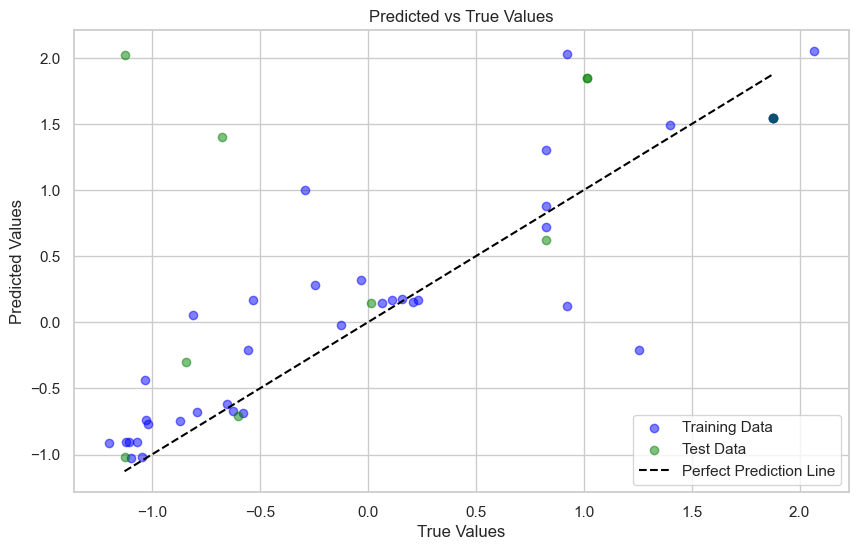

In [712]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_train.to_numpy(), model(X_train_tensor).detach().numpy(), alpha=0.5, label='Training Data', color='blue')
plt.scatter(y_test.to_numpy(), preds, alpha=0.5, label='Test Data', color='green')
plt.plot([min(y_test.to_numpy()), max(y_test.to_numpy())], [min(y_test.to_numpy()), max(y_test.to_numpy())], color='black', linestyle='--', label='Perfect Prediction Line')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

Epoch 1/300, Loss: 1.309763789176941, Test MSE: 1.0337049961090088, Test R-squared: -0.00274493582130253
Epoch 2/300, Loss: 0.9150908589363098, Test MSE: 1.0299248695373535, Test R-squared: 0.0009219791388008769
Epoch 3/300, Loss: 1.0985095500946045, Test MSE: 1.0265977382659912, Test R-squared: 0.004149344337054051
Epoch 4/300, Loss: 1.3287279605865479, Test MSE: 1.0235730409622192, Test R-squared: 0.007083513502613714
Epoch 5/300, Loss: 0.17897865176200867, Test MSE: 1.0209492444992065, Test R-squared: 0.00962872542473503
Epoch 6/300, Loss: 0.4869450628757477, Test MSE: 1.0187071561813354, Test R-squared: 0.011803597922168119
Epoch 7/300, Loss: 0.9638107419013977, Test MSE: 1.0167946815490723, Test R-squared: 0.01365891052311885
Epoch 8/300, Loss: 1.3375948667526245, Test MSE: 1.015092134475708, Test R-squared: 0.015310461476214954
Epoch 9/300, Loss: 0.5238682627677917, Test MSE: 1.0132397413253784, Test R-squared: 0.017107350004164412
Epoch 10/300, Loss: 1.5369678735733032, Test MSE

Epoch 96/300, Loss: 1.8468157052993774, Test MSE: 0.9608271718025208, Test R-squared: 0.06795019475743946
Epoch 97/300, Loss: 1.590595006942749, Test MSE: 0.9607798457145691, Test R-squared: 0.06799603076757066
Epoch 98/300, Loss: 0.6317487359046936, Test MSE: 0.960822582244873, Test R-squared: 0.0679545625428265
Epoch 99/300, Loss: 1.0212637186050415, Test MSE: 0.9608915448188782, Test R-squared: 0.06788772467785942
Epoch 100/300, Loss: 0.7189995646476746, Test MSE: 0.9609759449958801, Test R-squared: 0.06780581761790916
Epoch 101/300, Loss: 0.6686236262321472, Test MSE: 0.9609740376472473, Test R-squared: 0.06780762734420775
Epoch 102/300, Loss: 1.1555496454238892, Test MSE: 0.9609664678573608, Test R-squared: 0.06781504286976292
Epoch 103/300, Loss: 1.193700909614563, Test MSE: 0.960952877998352, Test R-squared: 0.06782826141311582
Epoch 104/300, Loss: 0.6386498212814331, Test MSE: 0.9609317779541016, Test R-squared: 0.06784863574619915
Epoch 105/300, Loss: 0.26559215784072876, Test

Epoch 193/300, Loss: 0.7943537831306458, Test MSE: 0.9609622955322266, Test R-squared: 0.06781910748697817
Epoch 194/300, Loss: 2.1689531803131104, Test MSE: 0.9609616994857788, Test R-squared: 0.06781954628242193
Epoch 195/300, Loss: 0.747947096824646, Test MSE: 0.9609621167182922, Test R-squared: 0.06781925994061444
Epoch 196/300, Loss: 0.537876546382904, Test MSE: 0.960962176322937, Test R-squared: 0.06781918520445407
Epoch 197/300, Loss: 0.31240662932395935, Test MSE: 0.9609619975090027, Test R-squared: 0.0678193032148614
Epoch 198/300, Loss: 1.1594070196151733, Test MSE: 0.9609621167182922, Test R-squared: 0.06781923132450218
Epoch 199/300, Loss: 1.0384438037872314, Test MSE: 0.9609619379043579, Test R-squared: 0.06781939949780236
Epoch 200/300, Loss: 0.6280098557472229, Test MSE: 0.9609619975090027, Test R-squared: 0.06781931922813966
Epoch 201/300, Loss: 0.34485816955566406, Test MSE: 0.9609619975090027, Test R-squared: 0.06781938881475491
Epoch 202/300, Loss: 1.9048267602920532

Epoch 291/300, Loss: 0.14179229736328125, Test MSE: 0.9609612226486206, Test R-squared: 0.06782009188575411
Epoch 292/300, Loss: 0.19996574521064758, Test MSE: 0.9609612226486206, Test R-squared: 0.06782009757735652
Epoch 293/300, Loss: 0.5754379034042358, Test MSE: 0.9609612226486206, Test R-squared: 0.06782008590053723
Epoch 294/300, Loss: 0.4889221787452698, Test MSE: 0.9609612226486206, Test R-squared: 0.06782008235457859
Epoch 295/300, Loss: 0.760327935218811, Test MSE: 0.9609612226486206, Test R-squared: 0.06782008215130708
Epoch 296/300, Loss: 0.21537844836711884, Test MSE: 0.9609612226486206, Test R-squared: 0.0678200821964785
Epoch 297/300, Loss: 0.2613285481929779, Test MSE: 0.9609612226486206, Test R-squared: 0.06782008224165004
Epoch 298/300, Loss: 0.47697943449020386, Test MSE: 0.9609612226486206, Test R-squared: 0.06782008206096424
Epoch 299/300, Loss: 1.1914442777633667, Test MSE: 0.9609613418579102, Test R-squared: 0.06782008978528176
Epoch 300/300, Loss: 0.532962977886

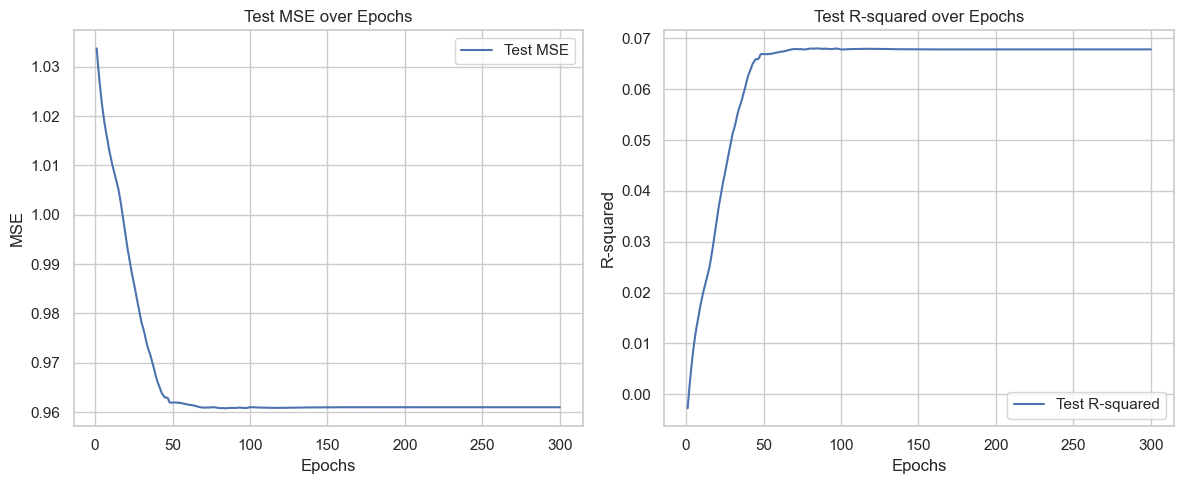

In [758]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import random

# Set the seed for reproducibility
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define the neural network model with more layers and L2 regularization
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, hidden3=32):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Function to train the model with learning rate scheduling and evaluation at each epoch
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=200):
    model.train()
    train_losses = []
    test_mse = []
    test_r2 = []
    
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        
        # Evaluate on the test set
        model.eval()
        predictions = []
        true_values = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                predictions.append(outputs)
                true_values.append(targets)
        predictions = torch.cat(predictions).numpy()
        true_values = torch.cat(true_values).numpy()
        
        mse = mean_squared_error(true_values, predictions)
        r2 = r2_score(true_values, predictions)
        
        train_losses.append(loss.item())
        test_mse.append(mse)
        test_r2.append(r2)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test MSE: {mse}, Test R-squared: {r2}')
        model.train()
    return train_losses, test_mse, test_r2, predictions

# Convert DataFrames to numpy arrays and then to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

# Create DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Create the model, criterion, optimizer, and learning rate scheduler
input_dim = X_train.shape[1]
model = RegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00015, weight_decay=0.01)  # L2 regularization added with weight_decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Train the model and capture metrics
train_losses, test_mse, test_r2, preds = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, 300)

# Plot MSE and R-squared over epochs
epochs = range(1, 301)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, test_mse, label='Test MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Test MSE over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_r2, label='Test R-squared')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.title('Test R-squared over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [745]:
r2_score(y_test, preds)

0.06782012264833459

Final MSE for all data: 0.7123191555341085
Final R-squared for all data: 0.2942455685297072


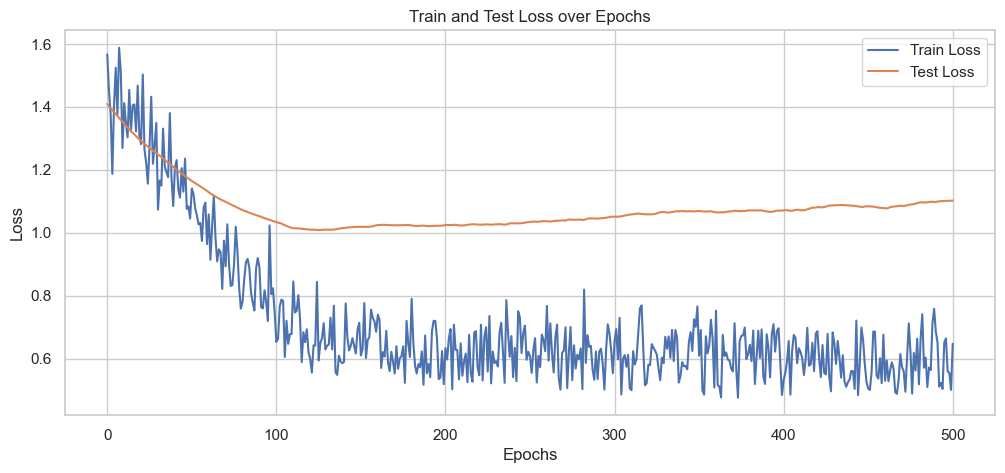

In [768]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time as tm
from sklearn.metrics import mean_squared_error, r2_score
import random

# Set the seed for reproducibility
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.x = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        x = self.x[i]
        y = self.y[i]   # Uses just the y as target
        return x, y

# The model
class BreakthPresNN(nn.Module):
    def __init__(self, input_shape):
        super(BreakthPresNN, self).__init__()
        self.input_shape = input_shape
        self.fc1 = nn.Linear(self.input_shape, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 1)
    
    def forward(self, x):
        x = x.view(-1, self.input_shape)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        return x

# Train function
def train_model(data_loader, model, loss_function, device, optimizer):
    num_batches = len(data_loader)
    model = model.to(device)
    total_loss = 0
    model.train()
    for X, y in data_loader:
        outputs = model(X)
        optimizer.zero_grad()
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    return avg_loss

# Test function
def test_model(data_loader, model, loss_function, device):
    output = torch.tensor([], device=device)
    num_batches = len(data_loader)
    model = model.to(device)
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output_step = model(X)
            loss = loss_function(output_step, y)
            total_loss += loss.item()
            output = torch.cat((output, output_step), 0)
    avg_loss = total_loss / num_batches
    return output, avg_loss

# Mean Squared Error function
def mean_squared_error(y_true, y_pred):
    summation = 0
    n = len(y_true)
    for i in range(n):
        difference = y_true[i] - y_pred[i]
        squared_difference = difference ** 2
        summation += squared_difference
    MSE = summation / n
    return MSE


number_of_points = X_train.shape[1]
batch_size = 16

y_train = y_train.values.reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test.reshape(-1, 1)


# Create the datasets
TrainDataset = MyDataset(X_train.to_numpy(), y_train)
TestDataset = MyDataset(X_test.to_numpy(), y_test)

TrainLoader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=True)
TestLoader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False)

# Training and test
learning_rate = 0.001
epoch = 500
model = BreakthPresNN(input_shape=number_of_points)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = np.zeros(epoch + 1)
test_loss = np.zeros(epoch + 1)

_, train_loss[0] = test_model(TrainLoader, model, loss_function, device)
_, test_loss[0] = test_model(TestLoader, model, loss_function, device)

total_time = 0
for i in range(epoch):
    t0 = tm.time()
    train_loss[i + 1] = train_model(TrainLoader, model, loss_function, device, optimizer=optimizer)
    _, test_loss[i + 1] = test_model(TestLoader, model, loss_function, device)
    step_time = tm.time() - t0
    total_time += step_time

# Prediction for all data
all_data = np.vstack((X_train, X_test))
all_targets = np.vstack((y_train, y_test))
AllDataset = MyDataset(all_data, all_targets)
AllLoader = DataLoader(AllDataset, batch_size=batch_size, shuffle=False)

prediction_all, final_total_loss = test_model(AllLoader, model, loss_function, device)
prediction_all = np.array(prediction_all.cpu())

# Calculate R-squared for all data
r2_all = r2_score(all_targets, prediction_all)

# Print final metrics
print(f'Final MSE for all data: {final_total_loss}')
print(f'Final R-squared for all data: {r2_all}')

# Plot loss curves
epochs = range(epoch + 1)
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.show()


(10,)

# Prediction of Breakthrough Pressure with 5 Variables: Direct Tests

In [714]:
# Load the dataset
df = pd.read_csv('33.csv')
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Permeability25 [nD],Porosity [%],Porosity25 [%],SSA [m2g-1],SSA25 [m2g-1],Pore radius [nm],Pore radius25 [nm],Clay content [%],Breakthrough pressure [MPa],Breakthrough pressure25 [MPa]
0,Amann-Hildenbrand 2013,Opalinus Clay,25,6.87,6.87,11.6,11.60,39.0,39.00,7.0,7.00,60,4.1,4.10
1,Hildenbrand et al. 2004,Boom Clay,20,557.24,454.59,24.4,24.07,20.1,18.70,170.0,175.90,3,5.8,3.45
2,Hildenbrand et al. 2004,Boom Clay,20,24.32,19.84,23.5,23.18,23.6,21.96,55.0,56.91,8,6.0,4.38
3,Hildenbrand et al. 2004,Boom Clay,20,64.84,52.90,23.4,23.08,20.6,19.17,155.0,160.38,31,5.4,3.72
4,Hildenbrand et al. 2004,Boom Clay,20,17.22,14.05,23.4,23.08,20.6,19.17,40.0,41.39,31,5.2,4.14


In [715]:
df.shape

(23, 14)

In [716]:
# Display the summary statistics
print("\nSummary statistics:")
df.describe()


Summary statistics:


,P’[MPa],Permeability [nD],Permeability25 [nD],Porosity [%],Porosity25 [%],SSA [m2g-1],SSA25 [m2g-1],Pore radius [nm],Pore radius25 [nm],Clay content [%],Breakthrough pressure [MPa],Breakthrough pressure25 [MPa]
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,16.652174,35848.343043,22497.976957,10.630870,10.390870,18.212174,15.976522,67.813043,74.533913,33.130435,4.739565,4.340000
std,4.858064,171085.707692,107348.235642,10.201478,10.043376,14.839113,14.236202,118.924553,135.796502,20.385611,4.049581,3.021112
min,10.000000,2.240000,2.040000,0.040000,0.040000,0.590000,0.450000,3.000000,3.000000,0.000000,0.100000,0.340000
25%,13.000000,6.935000,3.895000,0.130000,0.120000,7.395000,6.040000,15.000000,17.680000,20.000000,0.690000,2.160000
50%,15.000000,22.290000,17.280000,6.000000,5.670000,13.600000,12.840000,33.000000,38.890000,33.000000,5.200000,3.720000
75%,20.000000,52.920000,36.370000,23.400000,23.080000,21.100000,19.170000,62.500000,64.670000,52.000000,7.550000,5.285000
max,25.000000,820668.690000,514935.780000,24.400000,24.070000,48.200000,44.850000,570.000000,656.360000,60.000000,13.800000,11.000000


In [717]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Reference                        0
Rock                             0
P’[MPa]                          0
Permeability [nD]                0
Permeability25 [nD]              0
Porosity [%]                     0
Porosity25 [%]                   0
SSA [m2g-1]                      0
SSA25 [m2g-1]                    0
Pore radius [nm]                 0
Pore radius25 [nm]               0
Clay content [%]                 0
Breakthrough pressure [MPa]      0
Breakthrough pressure25 [MPa]    0
dtype: int64


In [718]:
# Check the data types of each column
print("\nData types of each column:")
print(df.dtypes)


Data types of each column:
Reference                         object
Rock                              object
P’[MPa]                            int64
Permeability [nD]                float64
Permeability25 [nD]              float64
Porosity [%]                     float64
Porosity25 [%]                   float64
SSA [m2g-1]                      float64
SSA25 [m2g-1]                    float64
Pore radius [nm]                 float64
Pore radius25 [nm]               float64
Clay content [%]                   int64
Breakthrough pressure [MPa]      float64
Breakthrough pressure25 [MPa]    float64
dtype: object


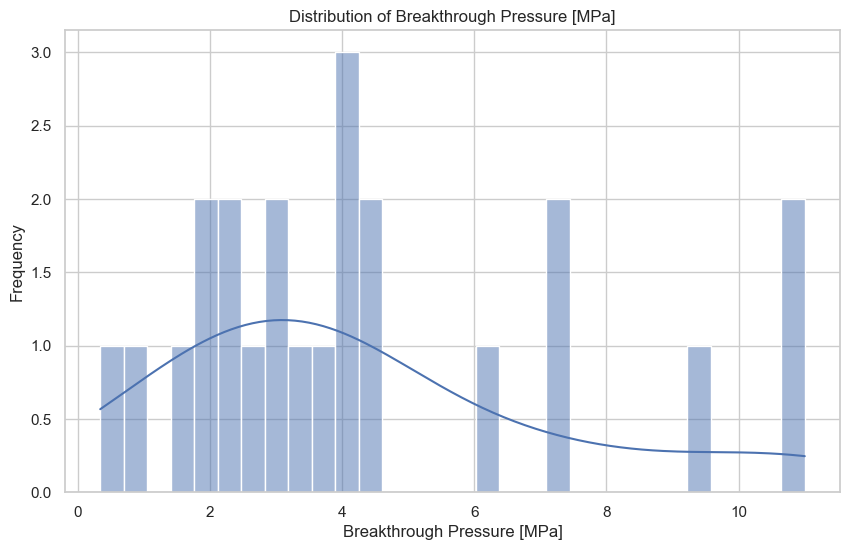

In [719]:

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Breakthrough pressure25 [MPa]'], bins=30, kde=True)
plt.title('Distribution of Breakthrough Pressure [MPa]')
plt.xlabel('Breakthrough Pressure [MPa]')
plt.ylabel('Frequency')
plt.show()

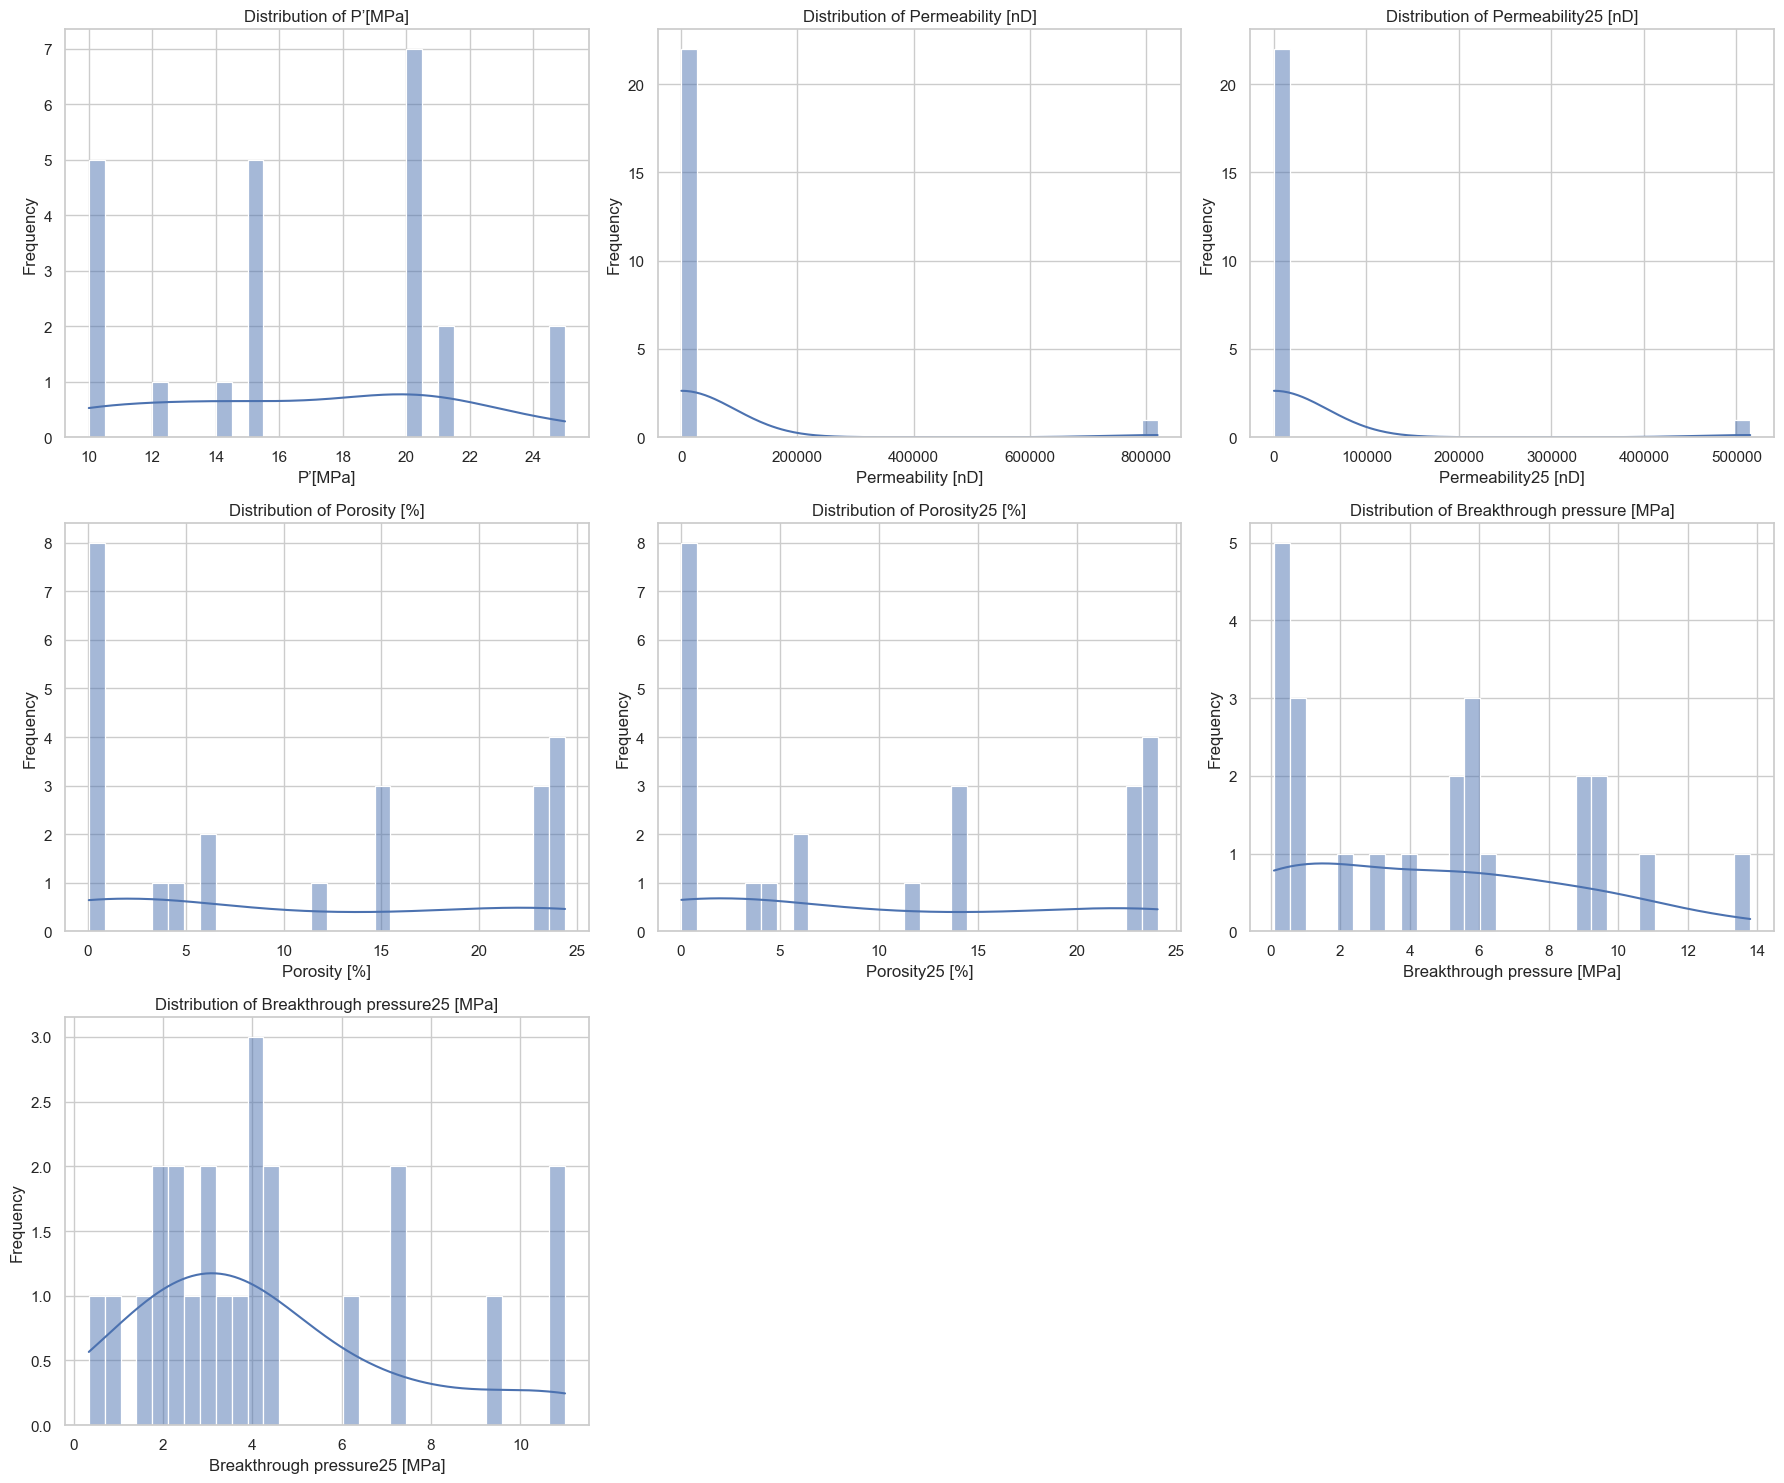

In [720]:

feature_columns = ['P’[MPa]', 'Permeability [nD]', 'Permeability25 [nD]', 
                   'Porosity [%]', 'Porosity25 [%]', 'Breakthrough pressure [MPa]', 
                   'Breakthrough pressure25 [MPa]']

num_features = len(feature_columns)
num_rows = (num_features + 2) // 3  
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(feature_columns):
    sns.histplot(df[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


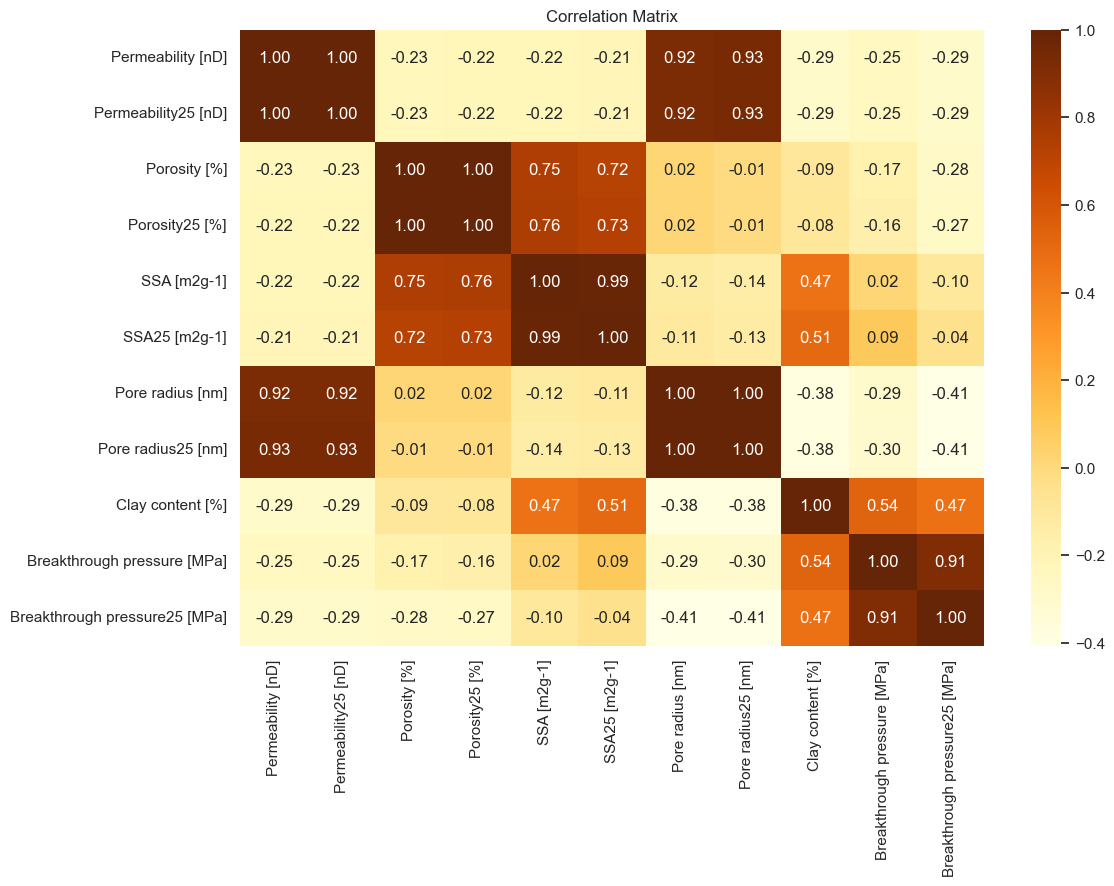

In [721]:
# Visualize correlations between features and the target variable
cols = ['Permeability [nD]',
       'Permeability25 [nD]', 'Porosity [%]', 'Porosity25 [%]', 'SSA [m2g-1]',
       'SSA25 [m2g-1]', 'Pore radius [nm]', 'Pore radius25 [nm]',
       'Clay content [%]', 'Breakthrough pressure [MPa]',
       'Breakthrough pressure25 [MPa]']
correlation_matrix = df[cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrBr', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [722]:
df.columns


Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]',
       'Permeability25 [nD]', 'Porosity [%]', 'Porosity25 [%]', 'SSA [m2g-1]',
       'SSA25 [m2g-1]', 'Pore radius [nm]', 'Pore radius25 [nm]',
       'Clay content [%]', 'Breakthrough pressure [MPa]',
       'Breakthrough pressure25 [MPa]'],
      dtype='object')